In [127]:
import sys
sys.path.append('../python/lib/')

import keras
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 #Latent space dimensions
validation_fraction = 0.2
energyCut = 35.0 #GeV

In [4]:
#signals used to train and test the model 
name = "eminus_Ele-Eta0-PhiPiOver2-Energy50_28x28.npy"
data = np.load(name)
print(data.shape)

(21000, 28, 28)


In [88]:
# importing generate function from lib util 
from util import generate
from util import sum_energy
from util import mean_eta

In [89]:
# importing plot_hist function from histograms
from histograms import plot_hist
from histograms import plot_energy_hist
from histograms import plot_cumulative

# Validation

In [8]:
mean_signal = np.mean(data, axis=0)

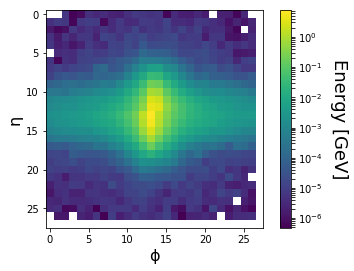

In [9]:
plot_hist(mean_signal)

In [13]:
energyArray = sum_energy(data)

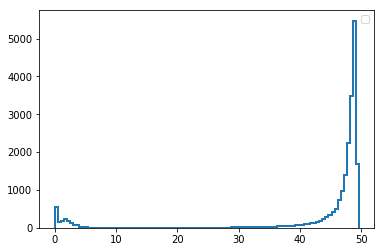

In [16]:
plot_energy_hist(energyArray,100)

In [21]:
print("Average Energy: " + str(np.mean(energyArray)))
print("Maximum Energy: "+str(np.max(energyArray)))
print("Minimum Energy: "+str(np.min(energyArray)))

Average Energy: 43.624549973010176
Maximum Energy: 49.61388795853418
Minimum Energy: 0.0


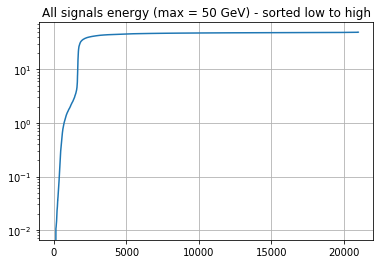

In [119]:
plt.title("All signals energy (max = 50 GeV) - sorted low to high")
plt.xlabel("Signal: 0 to "+str(data_t.shape[0]))
plt.ylabel("energy (i-th signal) [GeV]")
plt.grid()
plt.semilogy()
plt.plot((np.sort(energyArray)))
plt.show()

In [27]:
signal = energyArray

In [ ]:
#Redução do Conjunto de Dados (Apenas os sinais com Enegia <= 0.5 Gev)

In [29]:
data_t = data[energyArray > energyCut]

In [30]:
data_t.shape

(19060, 28, 28)

In [121]:
numSelectedEvents = data_t.shape[0]
print(numSelectedEvents)
signal_t = np.zeros(numSelectedEvents)
for i in range(limit):
    signal_t[i] = sum_energy(data_t[i])

19060


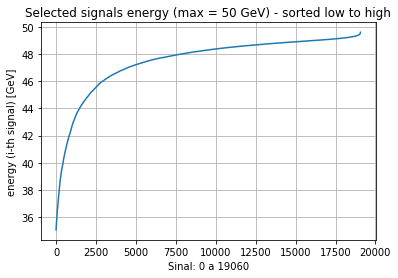

In [122]:
plt.title("Selected signals energy (max = 50 GeV) - sorted low to high")
plt.xlabel("Sinal: 0 a "+str(data_t.shape[0]))
plt.ylabel("energy (i-th signal) [GeV]")
plt.grid()
plt.plot((np.sort(signal_t)))
plt.show()

# More validation

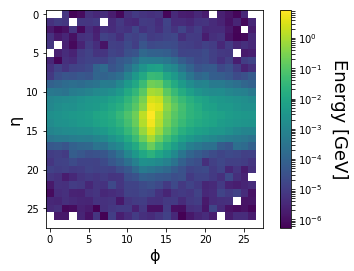

(28, 28)

In [47]:
mean_selected_signal = np.mean(data_t, axis=0)
plot_hist(mean_selected_signal)

# Model definition

In [52]:
# Using only the selected signal from now on
numSelectedEvents = data_t.shape[0]

## Notice that the model itself is still a black box for us...

In [41]:
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [42]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [43]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [44]:
class CustomVariationalLayer(keras.layers.Layer):
   
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
y = CustomVariationalLayer()([input_img, z_decoded])
    

In [103]:
## Compile model

In [45]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [104]:
## Separate training and validation datasets

In [60]:
print(numSelectedEvents)
numTrainEvents = int(np.round((1.0 - validation_fraction)*numSelectedEvents))
print("20% validation: "+str(numTrainEvents)+"/"+str(numSelectedEvents)+" for training")
data_t_train = data_t[:numTrainEvents,:,:]
data_t_test = data_t[numTrainEvents:,:,:]

19060
20% validation: 15248/19060 for training


In [105]:
## Final checks

In [61]:
data_t.shape

(19060, 28, 28)

In [62]:
data_t_train.shape

(15248, 28, 28)

In [63]:
data_t_test.shape

(3812, 28, 28)

In [126]:
## Fit - this takes time
### 80 minutes in Thiago's laptop

In [64]:
data_t_train = data_t_train.reshape(data_t_train.shape + (1,))
print(data_t_train.shape)
data_t_test = data_t_test.reshape(data_t_test.shape + (1,))
print(data_t_test.shape)
trainingHistory = vae.fit(x=data_t_train, y=None,shuffle=True,epochs=3,batch_size=100,validation_data=(data_t_test, None))

(15248, 28, 28, 1)
(3812, 28, 28, 1)
Train on 15248 samples, validate on 3812 samples
Epoch 1/3
15248/15248 [==============================] - 1664s 109ms/step - loss: -0.3014 - val_loss: -0.5712
Epoch 2/3
15248/15248 [==============================] - 1772s 116ms/step - loss: -0.6496 - val_loss: -0.6727
Epoch 3/3
15248/15248 [==============================] - 1703s 112ms/step - loss: -0.6776 - val_loss: -0.6858


In [69]:
# Build synthetic signals from the latent space of the autoencoder
limit_i = 80
limit_j = 80
signal_counter = 0 

partial_signals = np.zeros((limit_i*limit_j,28,28))
print(partial_signals.shape)
for i in range(limit_i):
    for j in range(limit_j):
        z_sample = np.array([[i, j]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        partial_signals[signal_counter,:,:] = x_decoded[0].reshape(28,28)
        signal_counter = signal_counter + 1 


(1, 28, 28)
(6400, 28, 28)


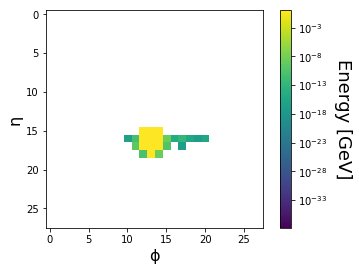

In [125]:
plot_hist(partial_signals[np.random.randint(0,partial_signals.shape[0])])

In [79]:
mean_synthetic_signal = np.mean(partial_signals,axis=0)
mean_synthetic_signal.shape

(28, 28)

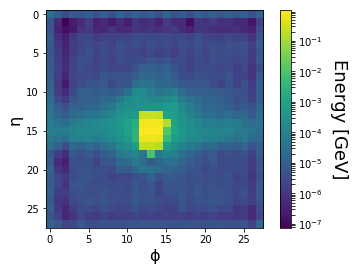

In [80]:
plot_hist(mean_synthetic_signal)

Average Energy: 8.622877930765664
Maximum Energy: 48.94799240902648
Minimum Energy: 6.00000000000046


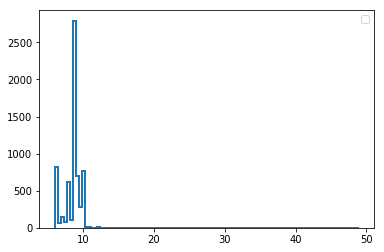

In [84]:
syntheticEnergyArray = sum_energy(partial_signals)
print("Average Energy: " + str(np.mean(syntheticEnergyArray)))
print("Maximum Energy: "+str(np.max(syntheticEnergyArray)))
print("Minimum Energy: "+str(np.min(syntheticEnergyArray)))
plot_energy_hist(syntheticEnergyArray,100)

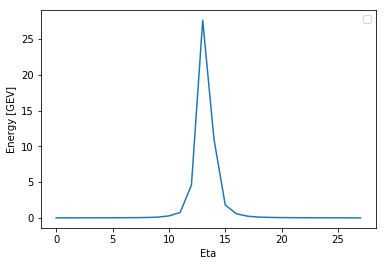

In [96]:
plot_cumulative(data=mean_eta(data_t), ylabel="Energy [GEV]", xlabel="Eta")

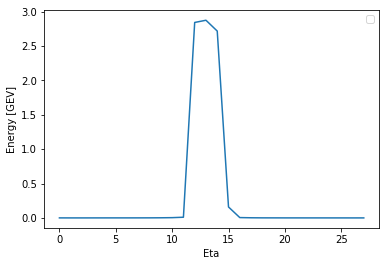

In [97]:
plot_cumulative(data=mean_eta(partial_signals), ylabel="Energy [GEV]", xlabel="Eta")